Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

Load the datasets

In [2]:
balancing_data = pd.read_csv('/Users/sravansridhar/Desktop/Edp_datathon/data/balancing_data.csv')
demand_load_data = pd.read_csv('/Users/sravansridhar/Desktop/Edp_datathon/data/demand_load_data.csv')
generation_data = pd.read_csv('/Users/sravansridhar/Desktop/Edp_datathon/data/generation_data.csv')
price_data = pd.read_csv('/Users/sravansridhar/Desktop/Edp_datathon/data/price_data.csv')

Convert GMT Time to datetime

In [3]:
for df in [balancing_data, demand_load_data, generation_data, price_data]:
    df['GMT Time'] = pd.to_datetime(df['GMT Time'])

Replace 'No Data Available' with NaN

In [4]:
for df in [balancing_data, demand_load_data, generation_data, price_data]:
    df.replace('No Data Available', np.nan, inplace=True)

Merge datasets on GMT Time

In [5]:
merged_data = pd.merge(balancing_data, demand_load_data, on='GMT Time')
merged_data = pd.merge(merged_data, generation_data, on='GMT Time')
merged_data = pd.merge(merged_data, price_data, on='GMT Time')

Convert all columns to numeric

In [6]:
for col in merged_data.columns:
    if merged_data[col].dtype == 'object':
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

Handle missing values

In [7]:
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

/var/folders/4n/xlvp5dd530zgvp5yzcjmsv400000gn/T/ipykernel_28668/907699182.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)
/var/folders/4n/xlvp5dd530zgvp5yzcjmsv400000gn/T/ipykernel_28668/907699182.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='bfill', inplace=True)


Extract the target variable (System Price)

In [8]:
system_price = merged_data['System Price (ESO Outturn) - GB (£/MWh)']

Plot the time series

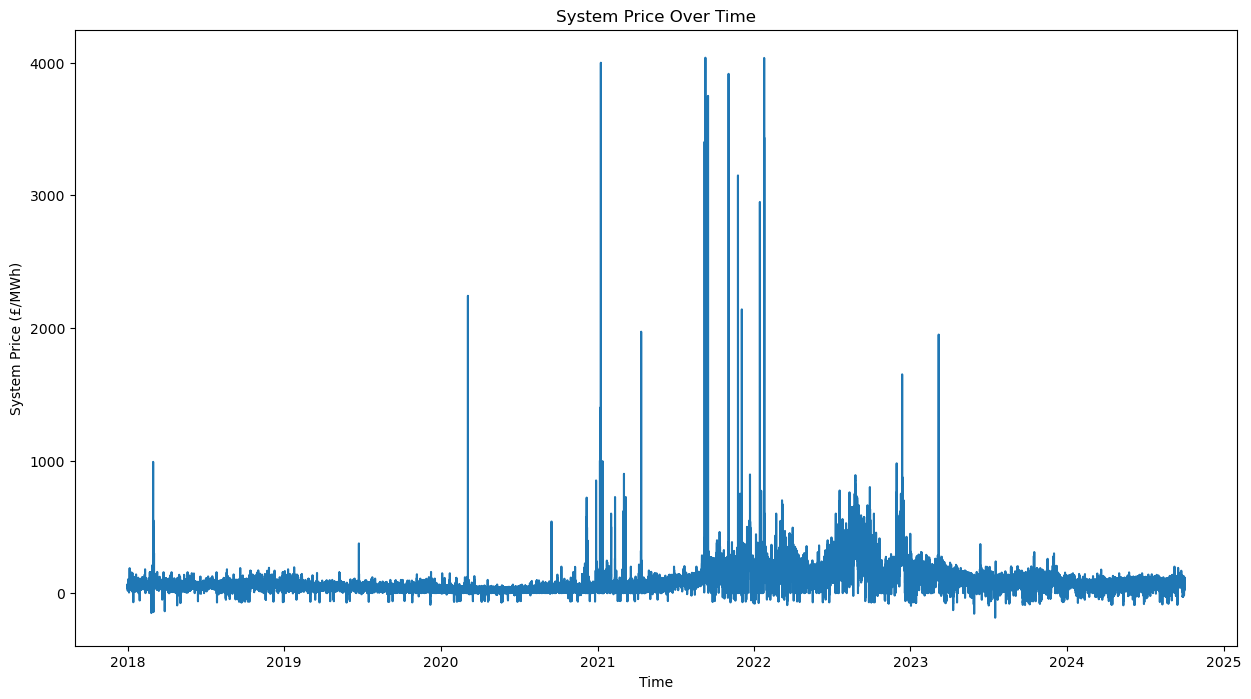

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(merged_data['GMT Time'], system_price)
plt.title('System Price Over Time')
plt.xlabel('Time')
plt.ylabel('System Price (£/MWh)')
plt.show()

Perform Augmented Dickey-Fuller test to check for stationarity

In [10]:
result = adfuller(system_price)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -13.11337639227544
p-value: 1.6176204491208921e-24
Critical Values:
   1%, -3.430405302770123
Critical Values:
   5%, -2.861564442999535
Critical Values:
   10%, -2.5667830101460924


Plot ACF and PACF to determine p and q

<Figure size 1200x600 with 0 Axes>

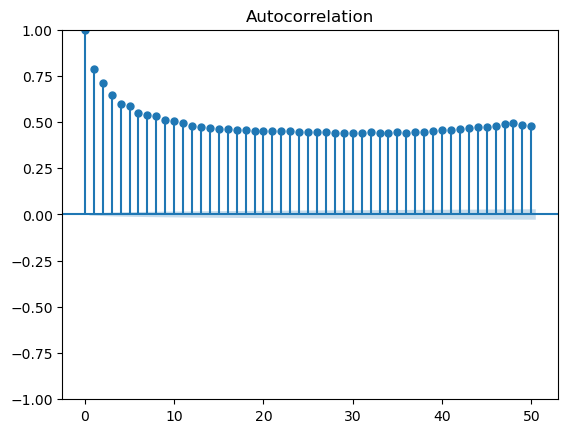

In [11]:
plt.figure(figsize=(12, 6))
plot_acf(system_price, lags=50)
plt.show()

<Figure size 1200x600 with 0 Axes>

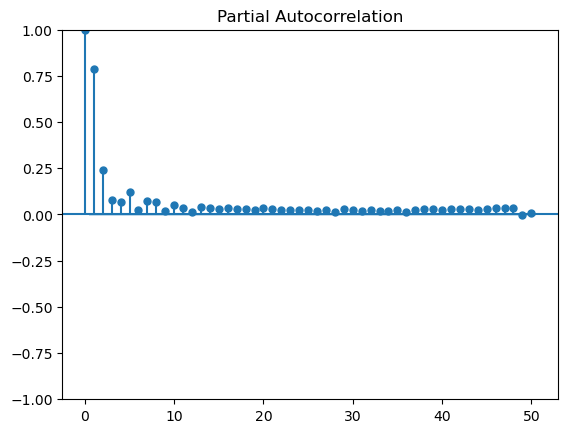

In [12]:
plt.figure(figsize=(12, 6))
plot_pacf(system_price, lags=50)
plt.show()

Fit ARIMA model with determined p and q

In [13]:
p = 0  # Example value, determine based on PACF plot
d = 0  # No differencing needed as the series is stationary
q = 1  # Example value, determine based on ACF plot

In [14]:
arima_model = ARIMA(system_price, order=(p, d, q))
arima_result = arima_model.fit()

Print model summary

In [15]:
print(arima_result.summary())

                                          SARIMAX Results                                          
Dep. Variable:     System Price (ESO Outturn) - GB (£/MWh)   No. Observations:               118320
Model:                                      ARIMA(0, 0, 1)   Log Likelihood             -686306.755
Date:                                     Wed, 04 Dec 2024   AIC                        1372619.511
Time:                                             01:58:44   BIC                        1372648.554
Sample:                                                  0   HQIC                       1372628.258
                                                  - 118320                                         
Covariance Type:                                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.6331      0.467    187.72

Forecast future values

In [16]:
forecast_steps = 48  # Forecasting for 24 hours with half-hour intervals
forecast = arima_result.forecast(steps=forecast_steps)

Plot the forecast

/var/folders/4n/xlvp5dd530zgvp5yzcjmsv400000gn/T/ipykernel_28668/2412336774.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  plt.plot(pd.date_range(start=merged_data['GMT Time'].iloc[-1], periods=forecast_steps, freq='30T'), forecast, label='Forecast')


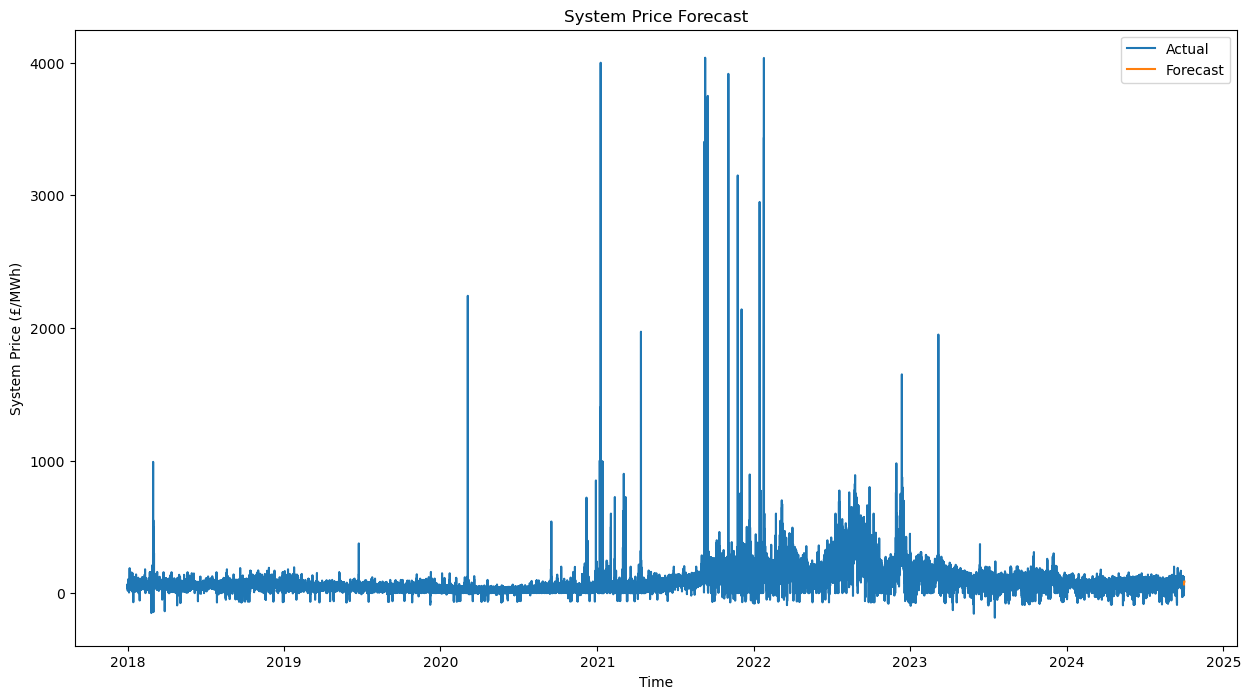

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(merged_data['GMT Time'], system_price, label='Actual')
plt.plot(pd.date_range(start=merged_data['GMT Time'].iloc[-1], periods=forecast_steps, freq='30T'), forecast, label='Forecast')
plt.title('System Price Forecast')
plt.xlabel('Time')
plt.ylabel('System Price (£/MWh)')
plt.legend()
plt.show()

Calculate RMSE for ARIMA model

In [18]:
actual_values = system_price[-forecast_steps:]  # Actual values for the forecast period
rmse_arima = mean_squared_error(actual_values, forecast, squared=False)
print(f'RMSE for ARIMA Model: {rmse_arima:.4f}')

RMSE for ARIMA Model: 47.9416


/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
# Splitting the data into training and testing sets
X = merged_data.drop(columns=['GMT Time', 'System Price (ESO Outturn) - GB (£/MWh)', 'NIV Outturn (+ve long) - GB (MW)'])

# Clean feature names
X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

y_price = merged_data['System Price (ESO Outturn) - GB (£/MWh)']
y_niv = merged_data['NIV Outturn (+ve long) - GB (MW)']

X_train, X_test, y_price_train, y_price_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train, X_test, y_niv_train, y_niv_test = train_test_split(X, y_niv, test_size=0.2, random_state=42)

In [37]:
# Define the base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),  # Using CPU version
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42))
]

# Define the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Define the voting regressor
voting_regressor = VotingRegressor(estimators=base_models)

# Define the bagging regressor
bagging_regressor = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=10, random_state=42)

# Train and evaluate the models
models = {
    'Stacking Regressor': stacking_regressor,
    'Voting Regressor': voting_regressor,
    'Bagging Regressor': bagging_regressor
}

for name, model in models.items():
    model.fit(X_train, y_price_train)
    y_price_pred = model.predict(X_test)
    rmse_price = mean_squared_error(y_price_test, y_price_pred, squared=False)
    print(f'{name} RMSE for System Price: {rmse_price:.4f}')
    
    model.fit(X_train, y_niv_train)
    y_niv_pred = model.predict(X_test)
    rmse_niv = mean_squared_error(y_niv_test, y_niv_pred, squared=False)
    print(f'{name} RMSE for Net Imbalance Volume: {rmse_niv:.4f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 94656, number of used features: 20
[LightGBM] [Info] Start training from score 87.827631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 75724, number of used features: 20
[LightGBM] [Info] Start training from score 87.575191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Stacking Regressor RMSE for System Price: 45.3524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 94656, number of used features: 20
[LightGBM] [Info] Start training from score 16.176883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 75724, number of used features: 20
[LightGBM] [Info] Start training from score 16.013425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Stacking Regressor RMSE for Net Imbalance Volume: 102.4748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 94656, number of used features: 20
[LightGBM] [Info] Start training from score 87.827631


/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Voting Regressor RMSE for System Price: 45.8437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4862
[LightGBM] [Info] Number of data points in the train set: 94656, number of used features: 20
[LightGBM] [Info] Start training from score 16.176883


/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Voting Regressor RMSE for Net Imbalance Volume: 114.3322


/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Bagging Regressor RMSE for System Price: 47.3020
Bagging Regressor RMSE for Net Imbalance Volume: 122.9395


/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [38]:
for name, model in models.items():
    print(f'{name} RMSE for System Price: {rmse_price:.4f}')
    print(f'{name} RMSE for Net Imbalance Volume: {rmse_niv:.4f}')

Stacking Regressor RMSE for System Price: 47.3020
Stacking Regressor RMSE for Net Imbalance Volume: 122.9395
Voting Regressor RMSE for System Price: 47.3020
Voting Regressor RMSE for Net Imbalance Volume: 122.9395
Bagging Regressor RMSE for System Price: 47.3020
Bagging Regressor RMSE for Net Imbalance Volume: 122.9395


In [53]:
import joblib

# Save the trained stacking regressor model
joblib.dump(stacking_regressor, 'stacking_regressor_model.pkl')

['stacking_regressor_model.pkl']

In [47]:
import pandas as pd
import re

def standardize_column_names(df):
    # Replace spaces and hyphens with underscores
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)
    # Remove parentheses
    df.columns = df.columns.str.replace(r'[()]', '', regex=True)
    # Remove all non-alphanumeric characters except underscores
    df.columns = df.columns.str.replace(r'[^0-9a-zA-Z_]', '', regex=True)
    # Optionally, convert to lowercase for consistency
    df.columns = df.columns.str.lower()
    return df



In [50]:
# Apply to training data
merged_data = standardize_column_names(merged_data)

# Apply to prediction data
october_1_data = standardize_column_names(october_1_data)


In [52]:
print("Columns in october_1_data:")
print(october_1_data.columns.tolist())


Columns in october_1_data:
['gmt_time', 'system_price_eso_outturn___gb_mwh', 'niv_outturn_ve_long___gb_mw', 'bm_bid_acceptances_total___gb_mw', 'bm_offer_acceptances_total___gb_mw', 'total_bsad_volume___turn_up___gb_mw', 'total_bsad_volume___turn_down___gb_mw', 'total_bsad_volume___total___gb_mw', 'intraday_volume_epex_outturn_apx_mid___gb_mwh', 'loss_of_load_probability___latest___gb_', 'actual_total_load___gb_mw', 'demand_outturn_itsdo___gb_mw', 'actual_aggregated_generation_by_type___biomass___gb_mw', 'actual_aggregated_generation_by_type___fossil_gas___gb_mw', 'actual_aggregated_generation_by_type___fossil_hard_coal___gb_mw', 'actual_aggregated_generation_by_type___fossil_oil___gb_mw', 'actual_aggregated_generation_by_type___hydro_pumped_storage___gb_mw', 'actual_aggregated_generation_by_type___hydro_run_of_river_and_poundage___gb_mw', 'actual_aggregated_generation_by_type___nuclear___gb_mw', 'actual_aggregated_generation_by_type___solar___gb_mw', 'actual_aggregated_generation_by_t

In [51]:
october_1_predictions_price = stacking_regressor.predict(
    october_1_data.drop(columns=[
        'GMT_Time',
        'System_Price_ESO_Outturn_GB_£/MWh_',
        'NIV_Outturn_+ve_long__GB_MW_'
    ])
)


KeyError: "['GMT_Time', 'System_Price_ESO_Outturn_GB_£/MWh_', 'NIV_Outturn_+ve_long__GB_MW_'] not found in axis"

Generating predictions for October 1, 2024

In [42]:
october_1_data = merged_data[merged_data['GMT Time'].dt.date == pd.to_datetime('2024-10-01').date()]
october_1_predictions_price = stacking_regressor.predict(october_1_data.drop(columns=['GMT Time', 'System Price (ESO Outturn) - GB (£/MWh)', 'NIV Outturn (+ve long) - GB (MW)']))
october_1_predictions_niv = stacking_regressor.predict(october_1_data.drop(columns=['GMT Time', 'System Price (ESO Outturn) - GB (£/MWh)', 'NIV Outturn (+ve long) - GB (MW)']))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Actual Aggregated Generation By Type - Biomass - GB (MW)
- Actual Aggregated Generation By Type - Fossil Gas - GB (MW)
- Actual Aggregated Generation By Type - Fossil Hard Coal - GB (MW)
- Actual Aggregated Generation By Type - Fossil Oil - GB (MW)
- Actual Aggregated Generation By Type - Hydro Pumped Storage - GB (MW)
- ...
Feature names seen at fit time, yet now missing:
- Actual_Aggregated_Generation_By_Type_Biomass_GB_MW_
- Actual_Aggregated_Generation_By_Type_Fossil_Gas_GB_MW_
- Actual_Aggregated_Generation_By_Type_Fossil_Hard_Coal_GB_MW_
- Actual_Aggregated_Generation_By_Type_Fossil_Oil_GB_MW_
- Actual_Aggregated_Generation_By_Type_Hydro_Pumped_Storage_GB_MW_
- ...


Combine ARIMA predictions with other model predictions

In [ ]:
combined_predictions_price = (october_1_predictions_price + forecast) / 2

Creating the output file

In [ ]:
output = pd.DataFrame({
    'GMT_TIME': october_1_data['GMT Time'],
    'SYSTEM_PRICE': combined_predictions_price,
    'NIV_OUTTURN': october_1_predictions_niv
})

In [ ]:
output.to_csv('predictions_october_1_2024.csv', index=False)
print(output.head())